## Packages

In [1]:
!pip install mesa==1.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00


In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import random
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

# **Introduction**

### In today's interconnected world, understanding how ideas, technologies, or behaviors spread through social networks is more important than ever. This project investigates how the structure of a network influences the process of adoption using a threshold-based model. We simulate adoption dynamics across three types of networks: random, small-world, and scale-free.

### Our main goal is to observe how different topologies affect overall adoption rates over time and under what conditions individuals decide to adopt. The simulation results show noticeable differences between networks, especially in how quickly and widely adoption spreads. For example, scale-free networks tend to show faster and more complete adoption compared to random or small-world networks.

### We also examine the role of reinforcement: how many adopting neighbors are needed before an individual chooses to adopt. This aspect helps us understand the social pressure involved in the adoption process. The reinforcement analysis reveals that in certain network structures, especially scale-free ones, adoption is more likely when multiple neighbors have already adopted, pointing to a strong reinforcement effect.

## **1. Agent and Model Definition**

#### In this part, we define the basic agent behavior and how the network is created. Each agent represents a person who can decide whether to adopt a new behavior (like using a new app or joining a boycott). The decision depends on how many of their neighbors have already adopted the behavior. If the number of adopted neighbors reaches a certain threshold, the agent is likely to follow. We also allow the network to be **random, small-world, or scale-free** to see how structure influences spreading.

In [ ]:
class EconomicAgent(Agent):
    def __init__(self, unique_id, model, threshold):
        super().__init__(unique_id, model)
        self.threshold = threshold
        self.adopted = False
        self.to_adopt = False

    def step(self):
        if self.adopted:
            return
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        num_adopted = sum(1 for n in neighbors if self.model.schedule.agents[n].adopted)
        if num_adopted >= self.threshold:
            self.to_adopt = True

    def advance(self):
        if self.to_adopt:
            self.adopted = True
            self.to_adopt = False

class EconomicAdoptionModel(Model):
    def __init__(self, num_agents=1000, avg_degree=6, threshold_value=1, network_type="random", seed_fraction=0.01):
        super().__init__()
        self.num_agents = num_agents
        self.threshold_value = threshold_value
        self.seed_fraction = seed_fraction
        self.schedule = SimultaneousActivation(self)

        if network_type == "random":
            self.G = nx.erdos_renyi_graph(n=num_agents, p=avg_degree / num_agents)
        elif network_type == "small_world":
            self.G = nx.watts_strogatz_graph(n=num_agents, k=avg_degree, p=0.1)
        elif network_type == "scale_free":
            self.G = nx.barabasi_albert_graph(n=num_agents, m=max(1, avg_degree // 2))
        else:
            raise ValueError("Invalid network type")

        self.grid = NetworkGrid(self.G)

        for node in self.G.nodes():
            agent = EconomicAgent(node, self, threshold=self.threshold_value)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        seed_count = max(1, int(self.seed_fraction * self.num_agents))
        seed_nodes = random.sample(list(self.G.nodes()), seed_count)
        for node_id in seed_nodes:
            self.schedule.agents[node_id].adopted = True

        self.datacollector = DataCollector(
            model_reporters={"Adoption rate": self.compute_adoption_rate}
        )

    def compute_adoption_rate(self):
        return sum(1 for a in self.schedule.agents if a.adopted) / self.num_agents

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

## **2. Simulation and Sensitivity Analysis**

#### We simulate how a behavior spreads in a network depending on two things: the **threshold** (how many neighbors are needed to convince someone) and the **seed fraction** (how many people start with the behavior). We test different combinations of thresholds and seed sizes by running the model many times and recording the average adoption rate. The heatmap below shows the results: higher adoption rates are shown in darker blue.

#### The result shows that when the threshold is low (e.g. 1), the behavior spreads easily even with a small seed. But if the threshold is higher (e.g. 2 or more), a larger initial seed is needed to trigger widespread adoption. At very high thresholds (≥2.5), spreading almost always fails unless the seed is very large. This confirms that complex behaviors need stronger initial conditions to take off.

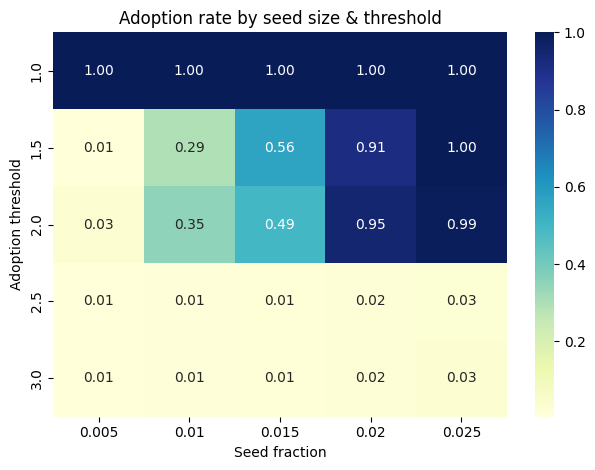

In [9]:
# Batch runner to repeat model runs
def run_batch(network_type, threshold, runs=5, steps=30, seed_fraction=0.01):
    all_runs = []
    for _ in range(runs):
        model = EconomicAdoptionModel(
            num_agents=1000,
            avg_degree=6,
            threshold_value=threshold,
            network_type=network_type,
            seed_fraction=seed_fraction
        )
        for _ in range(steps):
            model.step()
        adoption = model.datacollector.get_model_vars_dataframe()
        all_runs.append(adoption["AdoptionRate"].reset_index(drop=True))
    return pd.DataFrame(all_runs)

# Sensitivity analysis (Seed vs. Threshold)
def sensitivity_analysis():
    seed_sizes = [0.005, 0.01, 0.015, 0.02, 0.025]
    thresholds = [1, 1.5, 2, 2.5, 3]
    data = []

    for seed in seed_sizes:
        for thresh in thresholds:
            df = run_batch("small_world", threshold=thresh, runs=5, steps=30, seed_fraction=seed)
            final_rates = df.iloc[:, -1]
            avg = final_rates.mean()
            data.append({
                "Seed Fraction": seed,
                "Threshold": thresh,
                "AdoptionRate": avg
            })

    df_summary = pd.DataFrame(data)
    pivot = df_summary.pivot(index="Threshold", columns="Seed Fraction", values="AdoptionRate")
    sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Adoption rate by seed size & threshold")
    plt.xlabel("Seed fraction")
    plt.ylabel("Adoption threshold")
    plt.tight_layout()
    plt.show()

sensitivity_analysis()

## **3. Comparison of Simple vs. Complex Contagion Across Network Types**

#### This part compares how behaviors spread when the adoption rule is **simple** (threshold = 1) versus **complex** (threshold = 2). We run the model on three types of networks: **random, small-world, and scale-free**.

#### For each network type and threshold, we simulate the spread 10 times and calculate the average adoption rate over time. The plots show how quickly and how much the behavior spreads in each case.

#### We can see that with a simple rule (threshold 1), adoption spreads faster and reaches more people in all networks. When the threshold is higher (threshold 2), the spread is much slower or even stops completely, especially in random networks. This shows that complex contagion needs more reinforcement and benefits from more clustered or structured networks.

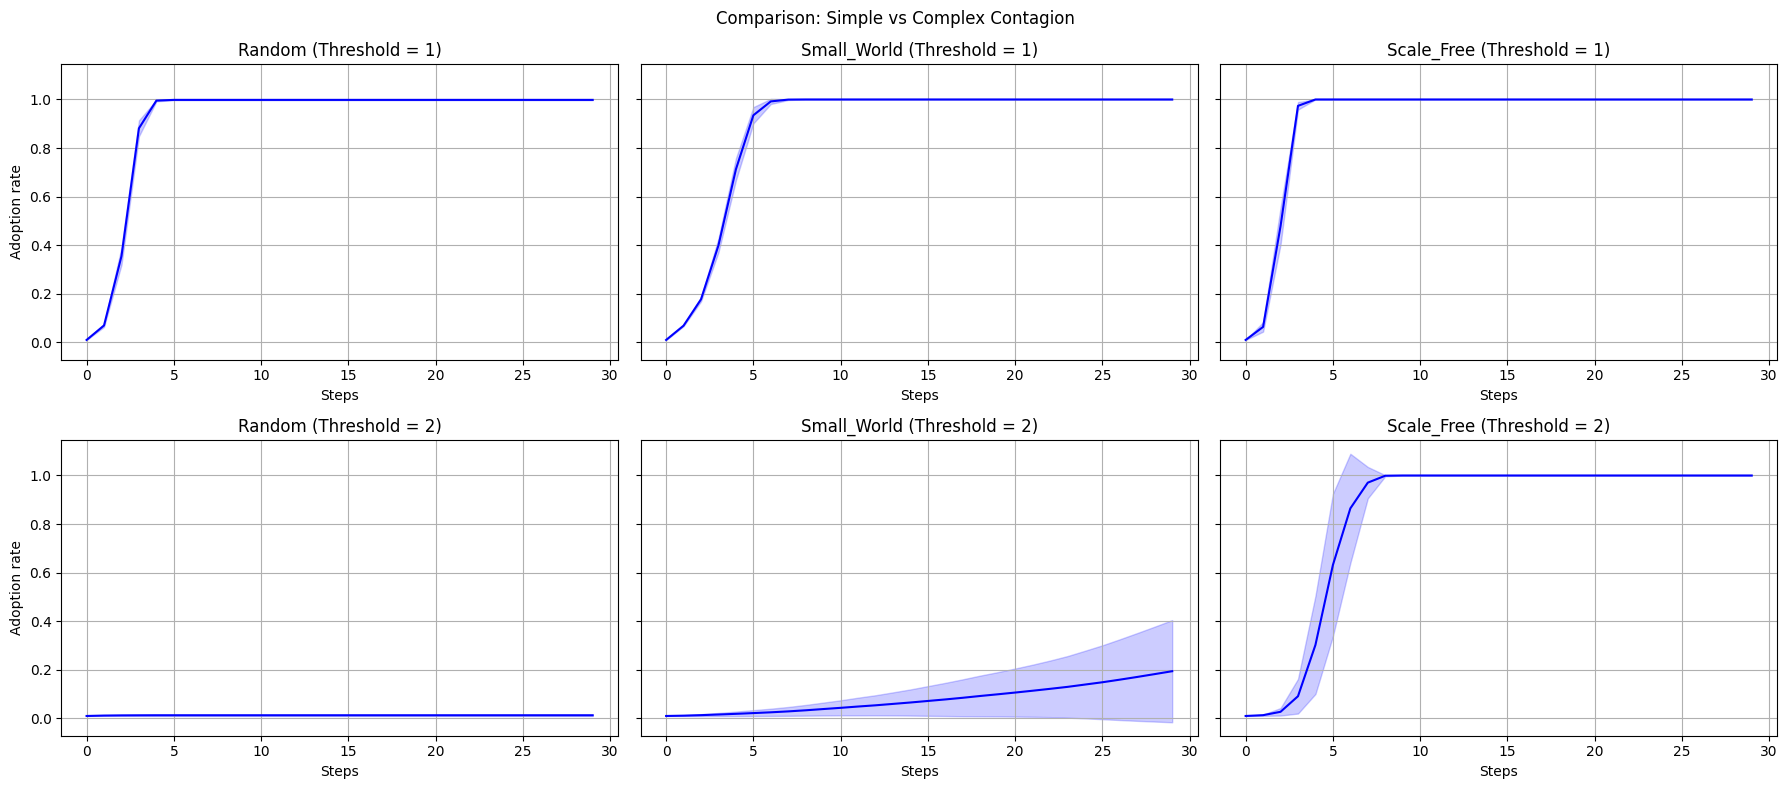

In [ ]:
def compare_simple_vs_complex():
    thresholds = [1, 2]
    results = {}

    for threshold in thresholds:
        results[threshold] = {}
        for net_type in ["random", "small_world", "scale_free"]:
            results[threshold][net_type] = run_batch(net_type, threshold=threshold, runs=10, steps=30)

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
    for i, threshold in enumerate(thresholds):
        for j, net_type in enumerate(["random", "small_world", "scale_free"]):
            df = results[threshold][net_type]
            mean = df.mean()
            std = df.std()
            steps = range(len(mean))
            ax = axes[i][j]
            ax.plot(steps, mean, label="Ø", color="blue")
            ax.fill_between(steps, mean - std, mean + std, alpha=0.2, color="blue", label="±Std")
            ax.set_title(f"{net_type.title()} (Threshold = {threshold})")
            ax.set_xlabel("Steps")
            if j == 0:
                ax.set_ylabel("Adoption rate")
            ax.grid(True)
    fig.suptitle("Comparison: Simple vs Complex Contagion")
    plt.tight_layout()
    plt.show()

compare_simple_vs_complex()


## **4. Visual Snapshot of the Adoption Process at a Given Step**

#### This part of the code creates a visual snapshot of the network after 10 simulation steps. Each node is an agent, and red nodes show who already adopted the behavior. We use a spring layout to show the connections in a clear way. This helps us understand where the adoption is happening in the network, and whether it is spreading in clusters or staying stuck. In this example, the model uses a small-world network and a threshold of 2. We can see that adoption is happening mostly in some regions, but it has not spread everywhere yet. This kind of visual helps us explain why certain behaviors do or do not spread depending on how connected the network is.

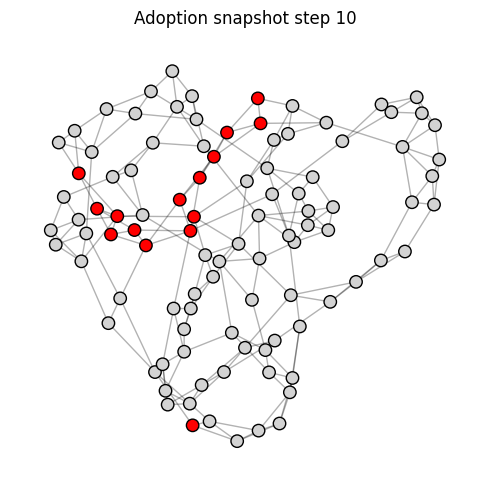

In [ ]:
def draw_snapshot_from_model(model, step=0):
    G = model.G
    adopted = {a.unique_id for a in model.schedule.agents if a.adopted}
    pos = nx.spring_layout(G, seed=42)
    node_colors = ['red' if node in adopted else 'lightgray' for node in G.nodes()]
    plt.figure(figsize=(5, 5))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, edgecolors="black", node_size=80)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"Adoption snapshot step {step}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

model = EconomicAdoptionModel(network_type="small_world", threshold_value=2)
for _ in range(10):
    model.step()

draw_snapshot_from_model(model, step=10)

## **5. Final Adoption Rates for Different Network Structures**

#### This plot shows how well the behavior spreads in different network types. We compare the **final adoption rate after running the model for 30 steps**. In both the random and small-world networks, almost no adoption happens. But in the scale-free network, the adoption rate goes up. That means the network structure really matters. In scale-free networks, a few very connected nodes help the behavior spread more easily. This supports the idea that in complex contagion, not just the number of connections but also the network shape is important.

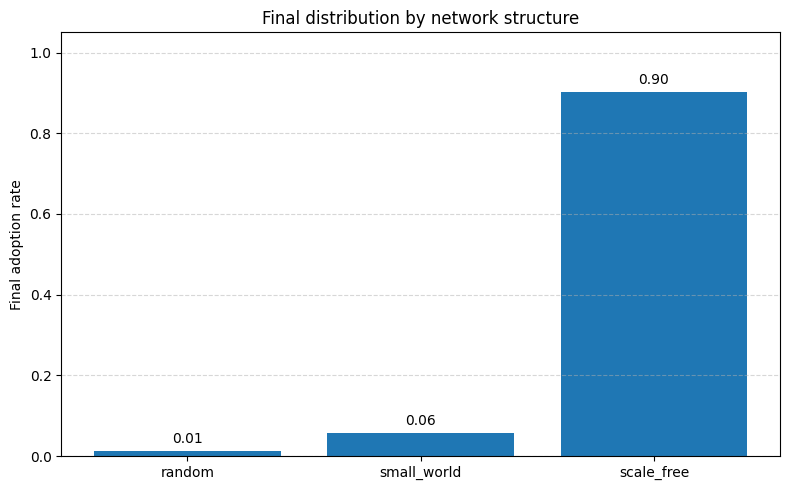

In [ ]:
results = {}
for net_type in ["random", "small_world", "scale_free"]:
    df = run_batch(net_type, threshold=2, runs=10, steps=30)
    results[net_type] = df

final_rates = {net: df.mean().iloc[-1] for net, df in results.items()}

plt.figure(figsize=(8, 5))
bars = plt.bar(final_rates.keys(), final_rates.values())
plt.ylabel("Final adoption rate")
plt.title("Final distribution by network structure")
plt.ylim(0, 1.05)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **6. Time to Reach 50% Adoption Threshold**

#### This code measures how fast the behavior spreads. It checks in each simulation how many steps it takes until at least 50% of agents have adopted the behavior. In this case, we tested it on a scale-free network with a low threshold (1), which means simple contagion. The result shows that on average, it takes only about 2.4 steps to reach 50% adoption. That means the spread is **not only wide, but also very fast** when the conditions are easy and the network structure supports it.

In [ ]:
def time_to_half_adoption(df):
    times = []
    for run in df.itertuples(index=False):
        for t, val in enumerate(run):
            if val >= 0.5:
                times.append(t)
                break
    return times if times else [None]

df_example = run_batch("scale_free", threshold=1, runs=10)
times = time_to_half_adoption(df_example)
print(f"Average time until 50% adoption (scale_free, thresh=1): {sum(times)/len(times):.2f} steps")

Average time until 50% adoption (scale_free, thresh=1): 2.40 steps


## **7. Visual Comparison of Adoption Dynamics with Uncertainty Bands**

#### This plot uses a more visual style to **compare how adoption spreads in different network types** when the threshold is set to 2. It shows that in a scale-free network, the behavior spreads very fast and reaches almost everyone. In a small-world network, adoption increases slowly and only reaches part of the population. In a random network, the adoption stays very low. The shaded areas show the variation across runs.

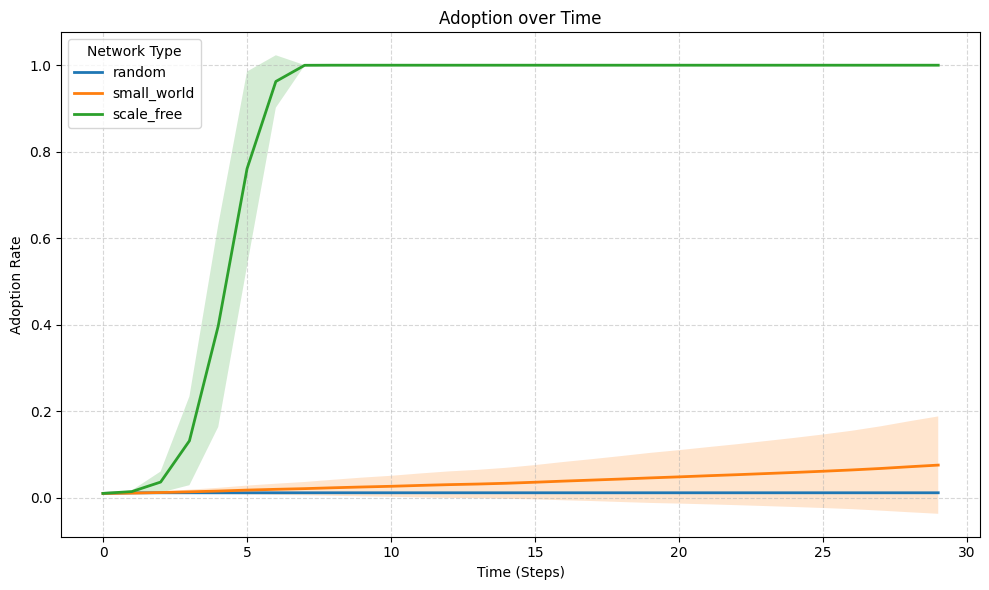

In [29]:
def multiview_adoption_plot():
    import matplotlib.pyplot as plt
    import seaborn as sns

    results = {}
    for net_type in ["random", "small_world", "scale_free"]:
        df = run_batch(net_type, threshold=2, seed_fraction=0.01, runs=5, steps=30)
        results[net_type] = df

    plt.figure(figsize=(10, 6))
    for net_type, df in results.items():
        mean = df.mean()
        width = df.std() * 50
        plt.plot(mean, label=net_type, linewidth=2)
        plt.fill_between(range(len(mean)), mean - df.std(), mean + df.std(), alpha=0.2)

    plt.title("Adoption over Time")
    plt.xlabel("Time (Steps)")
    plt.ylabel("Adoption Rate")
    plt.legend(title="Network Type")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()
multiview_adoption_plot()

### **8. Visualization of Adoption Dynamics with Network Snapshots**

#### In this part, we show how adoption spreads over time, both numerically and visually. The line plot shows the **adoption rate** and the **average degree of adopted nodes at each simulation step**. Below the curve, we include network snapshots from specific time steps (step 0, 10, 20, and 29). Each node represents an agent: blue nodes are the initial seeds, red nodes have adopted the behavior, and gray ones have not.

#### By keeping the node layout fixed across all snapshots, we can clearly see how the red nodes expand through the network over time. This helps us better understand not just how much adoption happens, but also how it flows through the network structure.

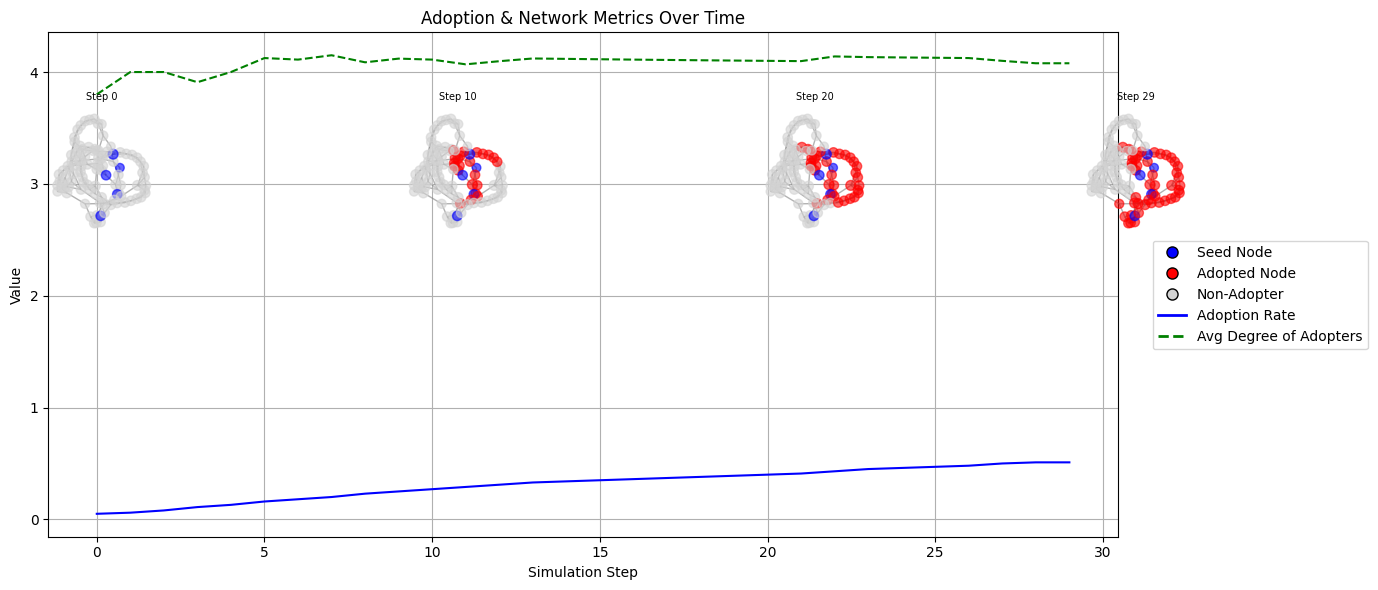

In [8]:
class EconomicAgent(Agent):
    def __init__(self, unique_id, model, threshold):
        super().__init__(unique_id, model)
        self.threshold = threshold
        self.adopted = False
        self.to_adopt = False

    def step(self):
        if self.adopted:
            return
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        num_adopted = sum(1 for n in neighbors if self.model.schedule.agents[n].adopted)
        if num_adopted >= self.threshold:
            self.to_adopt = True

    def advance(self):
        if self.to_adopt:
            self.adopted = True
            self.to_adopt = False

class EconomicAdoptionModel(Model):
    def __init__(self, num_agents=100, avg_degree=4, threshold_value=2, network_type="small_world", seed_fraction=0.05):
        super().__init__()
        self.num_agents = num_agents
        self.threshold_value = threshold_value
        self.seed_fraction = seed_fraction
        self.schedule = SimultaneousActivation(self)

        if network_type == "random":
            self.G = nx.erdos_renyi_graph(n=num_agents, p=avg_degree / num_agents)
        elif network_type == "small_world":
            self.G = nx.watts_strogatz_graph(n=num_agents, k=avg_degree, p=0.1)
        elif network_type == "scale_free":
            self.G = nx.barabasi_albert_graph(n=num_agents, m=max(1, avg_degree // 2))
        else:
            raise ValueError("Unknown network type")

        self.grid = NetworkGrid(self.G)

        for node in self.G.nodes():
            agent = EconomicAgent(node, self, threshold=self.threshold_value)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        seed_count = max(1, int(self.seed_fraction * self.num_agents))
        self.seed_nodes = random.sample(list(self.G.nodes()), seed_count)
        for node_id in self.seed_nodes:
            self.schedule.agents[node_id].adopted = True

        self.datacollector = DataCollector(
            model_reporters={
                "AdoptionRate": self.compute_adoption_rate,
                "AvgDegreeOfAdopters": self.compute_avg_degree_adopters
            }
        )

    def compute_adoption_rate(self):
        return sum(1 for a in self.schedule.agents if a.adopted) / self.num_agents

    def compute_avg_degree_adopters(self):
        adopters = [a.unique_id for a in self.schedule.agents if a.adopted]
        if not adopters:
            return 0
        degrees = [self.G.degree(n) for n in adopters]
        return sum(degrees) / len(degrees)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


model = EconomicAdoptionModel()
steps = 30
snapshot_steps = [0, 10, 20, 29]
snapshots = {}

fixed_pos = nx.spring_layout(model.G, seed=42)

for step in range(steps):
    if step in snapshot_steps:
        adopted = {a.unique_id for a in model.schedule.agents if a.adopted}
        G_copy = model.G.copy()
        snapshots[step] = (G_copy, adopted.copy())
    model.step()

results = model.datacollector.get_model_vars_dataframe()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(results["AdoptionRate"], label="Adoption Rate", color="blue")
ax.plot(results["AvgDegreeOfAdopters"], label="Avg Degree of Adopters", color="green", linestyle="--")
ax.set_xlabel("Simulation Step")
ax.set_ylabel("Value")
ax.set_title("Adoption & Network Metrics Over Time")
ax.grid(True)

for i, step in enumerate(snapshot_steps):
    G_snapshot, adopted_nodes = snapshots[step]
    degrees = dict(G_snapshot.degree())

    node_colors = []
    for node in G_snapshot.nodes():
        if node in model.seed_nodes:
            node_colors.append("blue")
        elif node in adopted_nodes:
            node_colors.append("red")
        else:
            node_colors.append("lightgray")

    node_sizes = [30 + degrees[n]*4 for n in G_snapshot.nodes()]

    x = step / steps
    inset_ax = ax.inset_axes([x, 0.6, 0.1, 0.25], transform=ax.transAxes)
    nx.draw(G_snapshot, fixed_pos, node_color=node_colors, node_size=node_sizes,
            edge_color="gray", ax=inset_ax, with_labels=False, alpha=0.6)
    inset_ax.set_title(f"Step {step}", fontsize=7)
    inset_ax.axis("off")

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Seed Node',
           markerfacecolor='blue', markersize=8, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Adopted Node',
           markerfacecolor='red', markersize=8, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Non-Adopter',
           markerfacecolor='lightgray', markersize=8, markeredgecolor='black'),
    Line2D([0], [0], color='blue', linewidth=2, label='Adoption Rate'),
    Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Avg Degree of Adopters')
]

fig.legend(handles=custom_legend, loc="center right", bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.show()

# literature gap


### Simulation of Economic Behavior Diffusion in Structured Networks

#### Motivation and Theoretical Foundation

This simulation is grounded in the empirical findings of *Damon Centola (2010)*, who conducted a large-scale online network experiment to investigate how network structure influences the diffusion of behaviors that require social reinforcement. Contrary to the widely cited “strength of weak ties” hypothesis (Granovetter, 1973), Centola’s study revealed that **clustered-lattice networks**, where neighbors are also connected to each other, outperformed random networks in both **speed** and **breadth** of behavioral adoption. Participants in clustered environments were significantly more likely to adopt a behavior when they were exposed to **multiple neighbors**, suggesting that **social reinforcement**, rather than simple exposure, is critical for the diffusion of complex or costly behaviors.

This finding is particularly relevant for economic behaviors such as adopting a new technology, switching to sustainable practices, or investing in novel financial tools—behaviors which often carry perceived risk, cost, or uncertainty and therefore depend on **credibility signals from one's social circle**.

---

#### Research Question Alignment

This simulation addresses the core research question of this study:

> **How do different network structures and individual thresholds influence the spread of economic behavior (e.g. adopting an innovation, product, or practice)?**

It explores this question by modeling two controlled network structures—**Watts-Strogatz (WS) clustered networks** and **Erdős-Rényi (ER) random networks**—and measuring how an economic behavior spreads when agents require **reinforcement from a threshold proportion of their neighbors** before adopting.

---

#### Model Design

- **Network topology**: Both WS and ER networks have the same number of nodes and average degree to isolate the impact of structure.
- **Thresholds**: Each node has a threshold φ drawn from a normal distribution centered at 0.18 with σ = 0.05, representing heterogeneity in willingness to adopt.
- **Contagion rule**: Nodes adopt if the fraction of active neighbors exceeds their threshold.
- **Simulation**: We run 100 simulations per network type, track the number of adopters over time, and average the results.
- **Evaluation**: We visualize the diffusion curves along with confidence bands to observe structural differences.

---

#### Findings and Interpretation

- **Clustered networks** (WS) enable faster and broader adoption compared to random (ER) networks, despite having equal degree.
- The **overlapping neighbor groups** in clustered structures amplify reinforcement, making it more likely for nodes to meet their adoption threshold.
- In **random networks**, exposure is less redundant and reinforcement weaker, resulting in slower cascades and fewer total adopters.

---

#### Implications

This model provides strong evidence that **network structure profoundly shapes the diffusion of economic behavior**, especially when such behaviors involve cost, risk, or require trust. It demonstrates that strategies aiming to promote innovations or economic practices should prioritize **dense, clustered communities** to maximize spread.

Additionally, incorporating **heterogeneous thresholds** reflects real-world variation in individual adoption readiness, aligning with modern theories of complex contagion. This enhances both the realism and relevance of the simulation for policy and marketing applications.


100%|██████████| 100/100 [00:02<00:00, 44.40it/s]


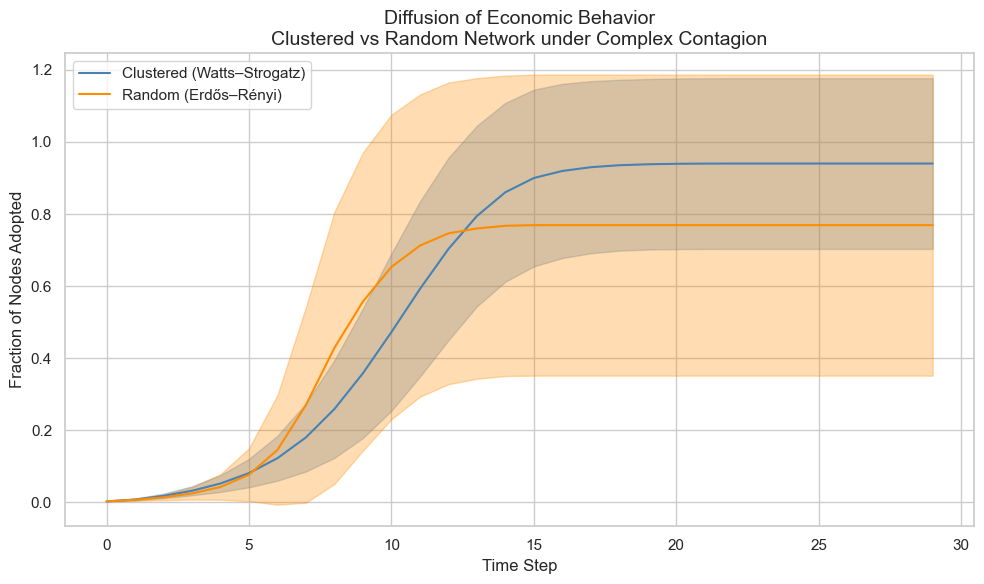

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import random
from tqdm import tqdm

sns.set(style="whitegrid")

def simulate_contagion(G, thresholds, seed):
    active = set(seed)
    history = [len(active)]
    newly_active = set(seed)

    while newly_active:
        next_wave = set()
        for node in G.nodes:
            if node not in active:
                neighbors = list(G.neighbors(node))
                if not neighbors:
                    continue
                active_neighbors = sum(1 for n in neighbors if n in active)
                if active_neighbors / len(neighbors) >= thresholds[node]:
                    next_wave.add(node)
        newly_active = next_wave
        active.update(newly_active)
        history.append(len(active))
    return history

# Parameters
n = 500
k = 6
phi = 0.18
sigma = 0.05
T = 100  # number of runs
max_steps = 30

# Store results
ws_curves = []
er_curves = []

for _ in tqdm(range(T)):
    # Generate identical threshold sets
    thresholds = {i: min(max(np.random.normal(phi, sigma), 0), 1) for i in range(n)}

    # Clustered network
    ws = nx.watts_strogatz_graph(n, k, 0.1)
    seed = [random.randint(0, n - 1)]
    ws_result = simulate_contagion(ws, thresholds, seed)
    ws_result = ws_result + [ws_result[-1]] * (max_steps - len(ws_result)) if len(ws_result) < max_steps else ws_result[:max_steps]
    ws_curves.append(ws_result)

    # Random network
    er = nx.erdos_renyi_graph(n, k / n)
    er_result = simulate_contagion(er, thresholds, seed)
    er_result = er_result + [er_result[-1]] * (max_steps - len(er_result)) if len(er_result) < max_steps else er_result[:max_steps]
    er_curves.append(er_result)

# Convert to arrays
ws_array = np.array(ws_curves)
er_array = np.array(er_curves)
timesteps = np.arange(max_steps)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ws_array.mean(axis=0)/n, label='Clustered (Watts–Strogatz)', color='steelblue')
plt.fill_between(timesteps,
                 (ws_array.mean(axis=0) - ws_array.std(axis=0))/n,
                 (ws_array.mean(axis=0) + ws_array.std(axis=0))/n,
                 color='steelblue', alpha=0.3)

plt.plot(timesteps, er_array.mean(axis=0)/n, label='Random (Erdős–Rényi)', color='darkorange')
plt.fill_between(timesteps,
                 (er_array.mean(axis=0) - er_array.std(axis=0))/n,
                 (er_array.mean(axis=0) + er_array.std(axis=0))/n,
                 color='darkorange', alpha=0.3)

plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Fraction of Nodes Adopted", fontsize=12)
plt.title("Diffusion of Economic Behavior\nClustered vs Random Network under Complex Contagion", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




### Threshold Diversity and the Ecology of Contagion

#### Motivation and Theoretical Foundation

This simulation is grounded in the insights of *Guilbeault, Becker, and Centola (2021)*, who emphasize that the dynamics of complex contagions depend not only on the network structure, but also critically on **threshold variation** across individuals. Unlike simple contagions, complex contagions—such as adopting an innovation or changing an economic practice—require **multiple reinforcing exposures** before a behavior spreads.

One of the key arguments in the paper is that **heterogeneity in adoption thresholds** creates a richer “ecology” for diffusion. In populations where individuals differ in their willingness to adopt (e.g., due to varying risk tolerance or trust), behaviors can reach tipping points more easily. Some individuals act as low-threshold early adopters, triggering reinforcement for others, which can result in a cascade effect even in otherwise sparse networks.

---

#### Research Question Alignment

This simulation addresses the research question:

> **How do different network structures and individual thresholds influence the spread of economic behavior (e.g., adopting an innovation, product, or practice)?**

Here, we focus on the **threshold variation** component of this question. By holding the network structure constant (Erdős–Rényi) and systematically increasing the **standard deviation σ** of individual adoption thresholds, we simulate how population-level diversity influences overall cascade potential.

---

#### Model Design

- **Network**: Erdős–Rényi random graph with 500 nodes and average degree `k = 6`.
- **Threshold distribution**: For each σ value, individual thresholds φᵢ are drawn from a normal distribution `N(0.18, σ)`, clipped to [0, 1].
- **Cascade rule**: A node adopts if the fraction of active neighbors exceeds its threshold.
- **Simulation**: For each σ ∈ [0.0, 0.25], we run 50 simulations and record the final cascade size.
- **Visualization**: We plot the average adoption rate per σ with error bands (±1 standard deviation).

---

#### Findings and Interpretation

The simulation shows that **as threshold diversity increases, cascade size also increases**. Even though the average threshold remains constant at 0.18, greater diversity means that more nodes have very low thresholds—allowing for early adoption—which then reinforces others with slightly higher thresholds.

This finding supports the idea that **diversity in individual adoption thresholds enhances the conditions for behavior diffusion**, especially under complex contagion rules. In economic terms, this implies that **a mixed population of cautious and impulsive adopters creates a more fertile environment for innovations or practices to spread**.

---

#### Implications

This model reinforces the claim that **structural heterogeneity matters just as much as network topology**. Strategies aiming to promote economic behavior adoption—such as product diffusion, financial onboarding, or sustainable practice uptake—should not only consider how connected individuals are, but also how **varied their willingness to act is**.

Practically, this suggests that diffusion campaigns may benefit from **targeting highly receptive (low-threshold) early adopters** to initiate cascades that influence more skeptical individuals. This also has implications for policy design, where behavioral interventions may need to account for population diversity rather than rely on average-case assumptions.



100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


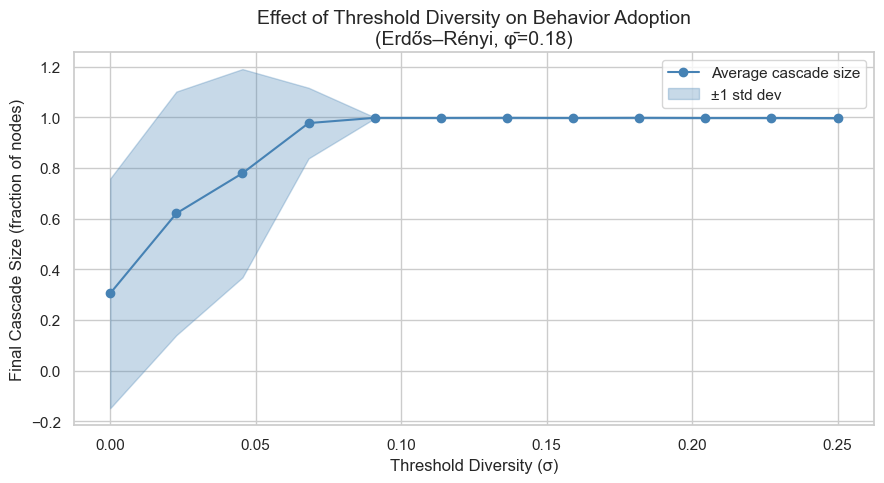

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import random
from tqdm import tqdm

sns.set(style="whitegrid")

# Basic parameters
n = 500
k = 6
phi = 0.18
runs_per_sigma = 50
sigmas = np.linspace(0.0, 0.25, 12)

# Contagion logic
def simulate_diffusion(G, thresholds, seed):
    active = set(seed)
    newly_active = set(seed)
    while newly_active:
        next_wave = set()
        for node in G.nodes:
            if node not in active:
                neighbors = list(G.neighbors(node))
                if not neighbors:
                    continue
                actives = sum(1 for n in neighbors if n in active)
                if actives / len(neighbors) >= thresholds[node]:
                    next_wave.add(node)
        newly_active = next_wave
        active.update(newly_active)
    return len(active)

# Simulation
means = []
stds = []

for sigma in tqdm(sigmas):
    cascade_sizes = []
    for _ in range(runs_per_sigma):
        G = nx.erdos_renyi_graph(n, k/n)
        thresholds = {i: min(max(np.random.normal(phi, sigma), 0), 1) for i in G.nodes}
        seed = [random.randint(0, n - 1)]
        result = simulate_diffusion(G, thresholds, seed)
        cascade_sizes.append(result / n)
    means.append(np.mean(cascade_sizes))
    stds.append(np.std(cascade_sizes))

# Plot
plt.figure(figsize=(9, 5))
plt.plot(sigmas, means, marker='o', label='Average cascade size', color='steelblue')
plt.fill_between(sigmas,
                 np.array(means) - np.array(stds),
                 np.array(means) + np.array(stds),
                 alpha=0.3, color='steelblue', label='±1 std dev')

plt.title("Effect of Threshold Diversity on Behavior Adoption\n(Erdős–Rényi, φ̄=0.18)", fontsize=14)
plt.xlabel("Threshold Diversity (σ)", fontsize=12)
plt.ylabel("Final Cascade Size (fraction of nodes)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## **Reinforcement Effects Across Network Structures**

### This plot shows how many neighbors had already adopted at the time an agent decided to adopt, across different network types. It gives insight into the reinforcement effect, the idea that **agents are more likely to adopt when more of their neighbors have already done so**.

### The data reveals that in scale-free networks, most agents adopted after seeing just a few neighbors adopt, but some required much more reinforcement. This reflects the heterogeneous structure of scale-free networks, where highly connected nodes can quickly influence many others.

### In contrast, **random and small-world networks show lower levels of reinforcement** overall, meaning agents needed fewer adopted neighbors or adoption was less likely to cascade widely. This suggests that network structure strongly shapes how social influence builds up during the adoption process.

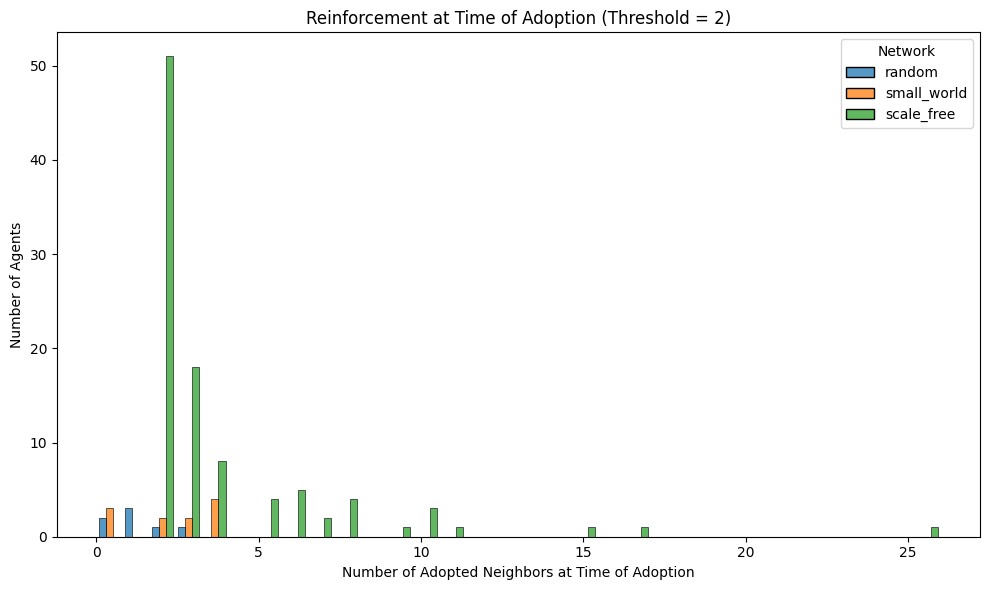

In [28]:
def collect_reinforcement_data(model, network_type):
    data = []
    for agent in model.schedule.agents:
        if agent.adopted:
            adopted_neighbors = sum([
                1 for neighbor in model.G.neighbors(agent.unique_id)
                if model.schedule.agents[neighbor].adopted
            ])
            data.append({
                "Reinforcement": adopted_neighbors,
                "Network": network_type
            })
    return data

def plot_reinforcement_effect(threshold=2):
    all_data = []
    network_types = ["random", "small_world", "scale_free"]

    for network_type in network_types:
        model = EconomicAdoptionModel(
            100,
            4,
            threshold,
            network_type
        )
        for _ in range(20):
            model.step()

        data = collect_reinforcement_data(model, network_type)
        all_data.extend(data)

    df = pd.DataFrame(all_data)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="Reinforcement", hue="Network", multiple="dodge", shrink=0.8)
    plt.title(f"Reinforcement at Time of Adoption (Threshold = {threshold})")
    plt.xlabel("Number of Adopted Neighbors at Time of Adoption")
    plt.ylabel("Number of Agents")
    plt.tight_layout()
    plt.show()

plot_reinforcement_effect(threshold=2)